# usALEX-5samples - Template

> *This notebook is a template that is executed by [usALEX-Batch](usALEX-Batch.ipynb) in order to fit E and S values of the FRET population for all the 5 smFRET samples.*
>
> *This notebook reads the environment variable NB_DATA_FILE to select which file to process.*

In [1]:
ph_sel_name = "all-ph"

In [2]:
data_id = "22d"

## Load software and filenames definitions

In [3]:
from fretbursts import *

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
-------------------------------------------------------------


 You are running FRETBursts (version 0.4rc10-7-gb2e1b5d).

 If you use this software in a publication, please cite it as:

   FRETBursts - An opensource single-molecule FRET bursts analysis toolkit.
   A. Ingargiola 2014. https://github.com/tritemio/FRETBursts

-------------------------------------------------------------


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [4]:
init_notebook()
from IPython.display import display

Data folder:

In [5]:
data_dir = './data/2012-11-26/'

In [6]:
import os
data_dir = os.path.abspath(data_dir) + '/'
assert os.path.exists(data_dir), "Path '%s' does not exist." % data_dir

List of data files:

In [7]:
from glob import glob
file_list = sorted(f for f in glob(data_dir + '*.hdf5') if '_BKG' not in f)
## Selection for POLIMI 2012-11-26 datatset
labels = ['17d', '27d', '7d', '12d', '22d']
files_dict = {lab: fname for lab, fname in zip(labels, file_list)}
files_dict

{'12d': 'C:\\Data\\Antonio\\software\\src\\multispot_paper\\data\\2012-11-26\\007_dsDNA_12d_3nM_green100u_red40u.hdf5',
 '17d': 'C:\\Data\\Antonio\\software\\src\\multispot_paper\\data\\2012-11-26\\004_dsDNA_17d_green100u_red40u.hdf5',
 '22d': 'C:\\Data\\Antonio\\software\\src\\multispot_paper\\data\\2012-11-26\\008_dsDNA_22d_500pM_green100u_red40u.hdf5',
 '27d': 'C:\\Data\\Antonio\\software\\src\\multispot_paper\\data\\2012-11-26\\005_dsDNA_27d_green100u_red40u.hdf5',
 '7d': 'C:\\Data\\Antonio\\software\\src\\multispot_paper\\data\\2012-11-26\\006_dsDNA_7d_green100u_red40u.hdf5'}

In [8]:
ph_sel_map = {'all-ph': Ph_sel('all'), 'Dex': Ph_sel(Dex='DAem'), 
              'DexDem': Ph_sel(Dex='Dem')}
ph_sel = ph_sel_map[ph_sel_name]

data_id, ph_sel_name

('22d', 'all-ph')

## Data load

Initial loading of the data:

In [9]:
d = loader.photon_hdf5(filename=files_dict[data_id])

## Laser alternation selection

At this point we have only the timestamps and the detector numbers:

In [10]:
d.ph_times_t, d.det_t

(array([      16030,       90752,      117066, ..., 47999910064,
        47999915269, 47999979355], dtype=int64),
 array([1, 1, 1, ..., 1, 0, 0], dtype=uint32))

We need to define some parameters: donor and acceptor ch, excitation period and donor and acceptor excitiations:

In [11]:
d.add(det_donor_accept=(0, 1), alex_period=4000, D_ON=(2850, 580), A_ON=(900, 2580))

We should check if everithing is OK with an alternation histogram:

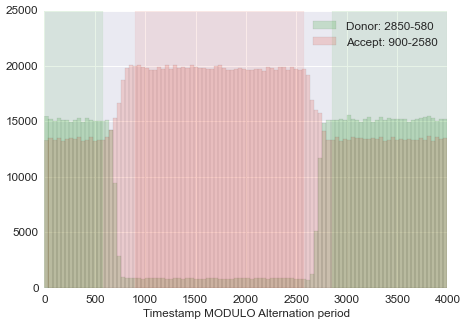

In [12]:
plot_alternation_hist(d)

If the plot looks good we can apply the parameters with:

In [13]:
loader.alex_apply_period(d)

#donor: 690971  #acceptor: 1411353 



##Measurements infos

All the measurement data is in the `d` variable. We can print it:

In [14]:
d

2012-11-26_008_dsDNA_22d_500pM_green100u_red40u G1.000

Or check the **measurements duration**:

In [15]:
d.time_max

599.99974193749995

##Compute background

Compute the background using automatic threshold:

In [16]:
d.calc_bg(bg.exp_fit, time_s=60, tail_min_us='auto', F_bg=1.7)

 - Calculating BG rates ... 

[DONE]


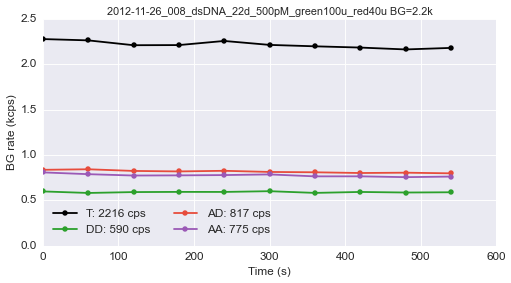

In [17]:
dplot(d, timetrace_bg)

In [18]:
d.rate_m, d.rate_dd, d.rate_ad, d.rate_aa

([2216.5749859728467],
 [590.63497787178903],
 [817.39941360088312],
 [775.62334440572033])

#Burst search and burst selection

In [19]:
d.burst_search(L=10, m=10, F=7, ph_sel=ph_sel)

 - Performing burst search (verbose=False) ...

[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   - Applying direct excitation correction.


   [DONE Counting D/A]


In [20]:
assert d.dir_ex == 0
assert d.leakage == 0

all


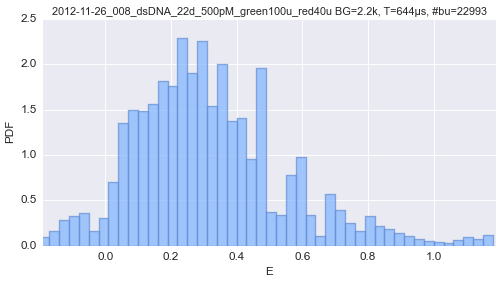

In [21]:
print d.ph_sel
dplot(d, hist_fret);

In [22]:
# if data_id in ['7d', '27d']:
#     ds = d.select_bursts(select_bursts.size, th1=20)
# else:
#     ds = d.select_bursts(select_bursts.size, th1=30)

In [23]:
ds = d.select_bursts(select_bursts.size, add_naa=False, th1=30)

In [24]:
n_bursts_all = ds.num_bursts[0]

In [25]:
def select_and_plot_ES(fret_sel, do_sel):
    ds_fret= ds.select_bursts(select_bursts.ES, **fret_sel)
    ds_do = ds.select_bursts(select_bursts.ES, **do_sel)
    bpl.plot_ES_selection(ax, **fret_sel)
    bpl.plot_ES_selection(ax, **do_sel)    
    return ds_fret, ds_do

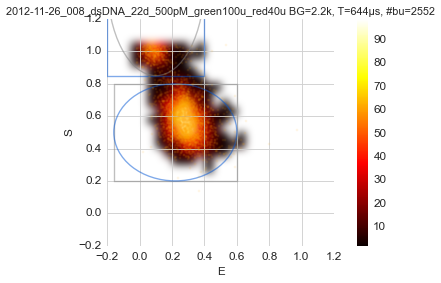

In [26]:
ax = dplot(ds, hist2d_alex, S_max_norm=2, scatter_alpha=0.1)

if data_id == '7d':
    fret_sel = dict(E1=0.60, E2=1.2, S1=0.2, S2=0.9, rect=False)
    do_sel = dict(E1=-0.2, E2=0.5, S1=0.8, S2=2, rect=True)    
    ds_fret, ds_do = select_and_plot_ES(fret_sel, do_sel)
    
elif data_id == '12d':
    fret_sel = dict(E1=0.30,E2=1.2,S1=0.131,S2=0.9, rect=False)
    do_sel = dict(E1=-0.4, E2=0.4, S1=0.8, S2=2, rect=False)
    ds_fret, ds_do = select_and_plot_ES(fret_sel, do_sel)

elif data_id == '17d':
    fret_sel = dict(E1=0.01, E2=0.98, S1=0.14, S2=0.88, rect=False)
    do_sel = dict(E1=-0.4, E2=0.4, S1=0.80, S2=2, rect=False)
    ds_fret, ds_do = select_and_plot_ES(fret_sel, do_sel)

elif data_id == '22d':
    fret_sel = dict(E1=-0.16, E2=0.6, S1=0.2, S2=0.80, rect=False)
    do_sel = dict(E1=-0.2, E2=0.4, S1=0.85, S2=2, rect=True)
    ds_fret, ds_do = select_and_plot_ES(fret_sel, do_sel)    

elif data_id == '27d':
    fret_sel = dict(E1=-0.1, E2=0.5, S1=0.2, S2=0.82, rect=False)
    do_sel = dict(E1=-0.2, E2=0.4, S1=0.88, S2=2, rect=True)
    ds_fret, ds_do = select_and_plot_ES(fret_sel, do_sel)    

In [27]:
n_bursts_do = ds_do.num_bursts[0]
n_bursts_fret = ds_fret.num_bursts[0]

n_bursts_do, n_bursts_fret

(403, 2045)

In [28]:
d_only_frac = 1.*n_bursts_do/(n_bursts_do + n_bursts_fret)
print 'D-only fraction:', d_only_frac

D-only fraction: 0.164624183007


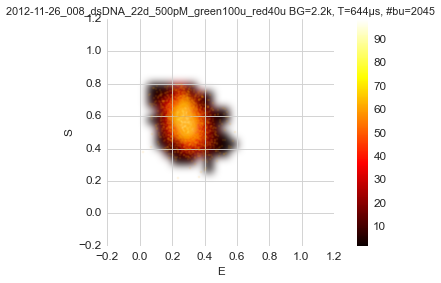

In [29]:
dplot(ds_fret, hist2d_alex, scatter_alpha=0.1);

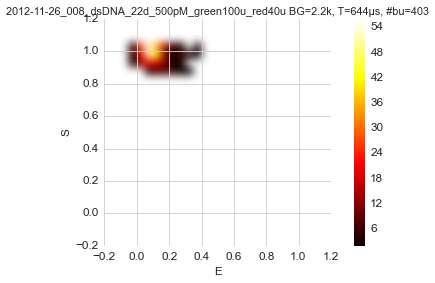

In [30]:
dplot(ds_do, hist2d_alex, S_max_norm=2, scatter=False);

In [31]:
bandwidth = 0.03

E_range_do = (-0.1, 0.15)
E_ax = np.r_[-0.2:0.401:0.0002]

E_pr_do_kde = bext.fit_bursts_kde_peak(ds_do, bandwidth=bandwidth, weights='size', 
                                       x_range=E_range_do, x_ax=E_ax, save_fitter=True)

all: E_peak = 9.24%


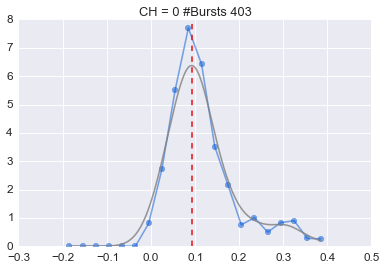

In [32]:
mfit.plot_mfit(ds_do.E_fitter, plot_kde=True, bins=np.r_[E_ax.min(): E_ax.max(): bandwidth])
plt.xlim(-0.3, 0.5)
print "%s: E_peak = %.2f%%" % (ds.ph_sel, E_pr_do_kde*100)

In [33]:
nt_th1 = 50

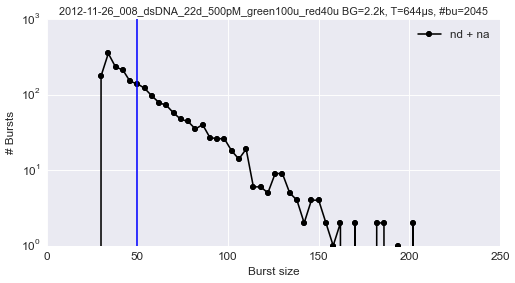

In [34]:
dplot(ds_fret, hist_size, which='all', add_naa=False)
xlim(-0, 250)
plt.axvline(nt_th1)

In [35]:
Th_nt = np.arange(35, 120)
nt_th = np.zeros(Th_nt.size)
for i, th in enumerate(Th_nt):
    ds_nt = ds_fret.select_bursts(select_bursts.size, th1=th)
    nt_th[i] = (ds_nt.nd[0]  + ds_nt.na[0]).mean() - th

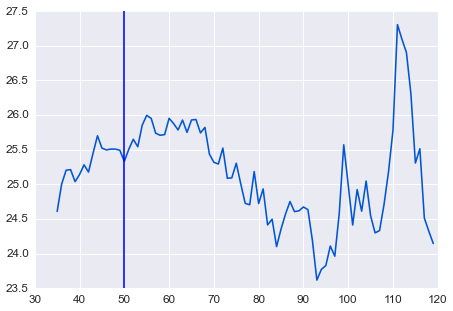

In [36]:
plt.figure()
plot(Th_nt, nt_th)
plt.axvline(nt_th1)

In [37]:
nt_mean = nt_th[np.where(Th_nt == nt_th1)][0]
nt_mean

25.330934087662214

#Fret fit

Max position of the Kernel Density Estimation (KDE):

In [38]:
E_pr_fret_kde = bext.fit_bursts_kde_peak(ds_fret, bandwidth=bandwidth, weights='size')
E_fitter = ds_fret.E_fitter

In [39]:
E_fitter.histogram(bins=np.r_[-0.1:1.1:0.03])

In [40]:
E_fitter.fit_histogram(mfit.factory_gaussian(center=0.5))

 - Adding parameter "fwhm"


In [41]:
display(E_fitter.params*100)

,sigma,center,amplitude
0,7.084236,27.98184,97.46669


all
KDE peak 27.68 


,sigma,center,amplitude
0,7.084236,27.98184,97.46669


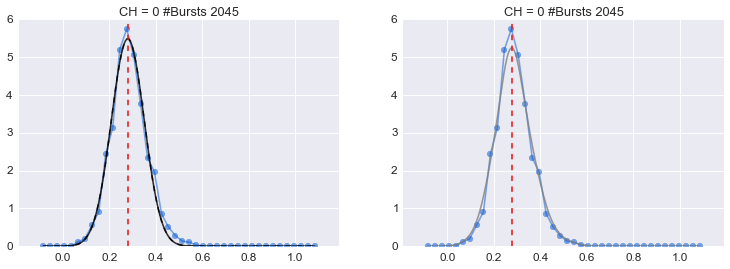

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4.5))
mfit.plot_mfit(E_fitter, ax=ax[0])
mfit.plot_mfit(E_fitter, plot_model=False, plot_kde=True, ax=ax[1])
print '%s\nKDE peak %.2f ' % (ds_fret.ph_sel, E_pr_fret_kde*100)
display(E_fitter.params*100)

In [43]:
# ds_fret.add(E_fitter = E_fitter)
# dplot(ds_fret, hist_fret_kde, weights='size', bins=np.r_[-0.2:1.2:bandwidth], bandwidth=bandwidth);
# plt.axvline(E_pr_fret_kde, ls='--', color='r')
# print ds_fret.ph_sel, E_pr_fret_kdedd

Weighted mean of $E$ of each burst:

In [44]:
ds_fret.fit_E_m(weights='size')

array([ 0.28568412])

Gaussian fit (no weights):

In [45]:
ds_fret.fit_E_generic(fit_fun=bl.gaussian_fit_hist, bins=np.r_[-0.1:1.1:0.03], weights=None)

array([ 0.28189027])

Gaussian fit (using burst size as weights):

In [46]:
ds_fret.fit_E_generic(fit_fun=bl.gaussian_fit_hist, bins=np.r_[-0.1:1.1:0.005], weights='size')

array([ 0.28010381])

In [47]:
E_kde_w = E_fitter.kde_max_pos[0]
E_gauss_w = E_fitter.params.loc[0, 'center']
E_gauss_w_sig = E_fitter.params.loc[0, 'sigma']
E_gauss_w_err = float(E_gauss_w_sig/np.sqrt(ds_fret.num_bursts[0]))
E_kde_w, E_gauss_w, E_gauss_w_sig, E_gauss_w_err

(0.27680000000001365,
 0.27981841178247313,
 0.07084235912969739,
 0.0015665575682686432)

# Stoichiometry fit

Max position of the Kernel Density Estimation (KDE):

In [48]:
S_pr_fret_kde = bext.fit_bursts_kde_peak(ds_fret, burst_data='S', bandwidth=0.03) #weights='size', add_naa=True)
S_fitter = ds_fret.S_fitter

In [49]:
S_fitter.histogram(bins=np.r_[-0.1:1.1:0.03])
S_fitter.fit_histogram(mfit.factory_gaussian(), center=0.5)

 - Adding parameter "fwhm"


all
KDE peak 56.36 


,sigma,center,amplitude
0,11.2976,56.43693,102.3941


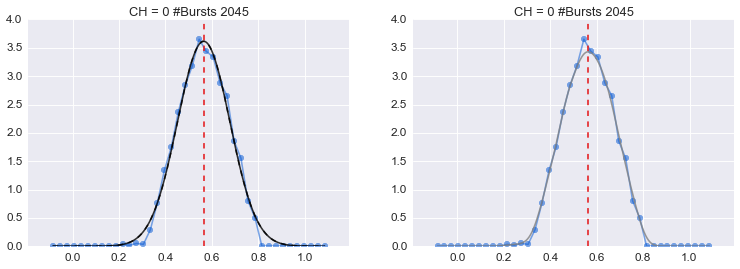

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4.5))
mfit.plot_mfit(S_fitter, ax=ax[0])
mfit.plot_mfit(S_fitter, plot_model=False, plot_kde=True, ax=ax[1])
print '%s\nKDE peak %.2f ' % (ds_fret.ph_sel, S_pr_fret_kde*100)
display(S_fitter.params*100)

In [51]:
S_kde = S_fitter.kde_max_pos[0]
S_gauss = S_fitter.params.loc[0, 'center']
S_gauss_sig = S_fitter.params.loc[0, 'sigma']
S_gauss_err = float(S_gauss_sig/np.sqrt(ds_fret.num_bursts[0]))
S_kde, S_gauss, S_gauss_sig, S_gauss_err

(0.56360000000002186,
 0.5643693152586078,
 0.11297599404829906,
 0.002498270818240495)

The Maximum likelihood fit for a Gaussian population is the mean:

In [52]:
S = ds_fret.S[0]
S_ml_fit = (S.mean(), S.std())
S_ml_fit

(0.56316530414823318, 0.10295200209301188)

Computing the weighted mean and weighted standard deviation we get:

In [53]:
weights = bl.fret_fit.get_weights(ds_fret.nd[0], ds_fret.na[0], weights='size', naa=ds_fret.naa[0], gamma=1.)
S_mean = np.dot(weights, S)/weights.sum()
S_std_dev = np.sqrt(
        np.dot(weights, (S - S_mean)**2)/weights.sum())
S_wmean_fit = [S_mean, S_std_dev]
S_wmean_fit

[0.55099298602807811, 0.10127469215586463]

# Save data to file

In [54]:
sample = data_id

The following string contains the list of variables to be saved. When saving, the order of the variables is preserved.

In [55]:
variables = ('sample n_bursts_all n_bursts_do n_bursts_fret '
             'E_kde_w E_gauss_w E_gauss_w_sig E_gauss_w_err S_kde S_gauss S_gauss_sig S_gauss_err '
             'E_pr_do_kde nt_mean\n')

This is just a trick to format the different variables:

In [56]:
var_dict = {name: eval(name) for name in variables.split()}
var_fmt = ' '.join(['{%s}' % name for name in variables.split()]) + '\n'
data_str = var_fmt.format(**var_dict)

In [57]:
data_str = var_fmt.format(**var_dict)

In [58]:
print variables
print data_str

sample n_bursts_all n_bursts_do n_bursts_fret E_kde_w E_gauss_w E_gauss_w_sig E_gauss_w_err S_kde S_gauss S_gauss_sig S_gauss_err E_pr_do_kde nt_mean

22d 2552 403 2045 0.2768 0.279818411782 0.0708423591297 0.00156655756827 0.5636 0.564369315259 0.112975994048 0.00249827081824 0.0924 25.3309340877



In [59]:
# NOTE: The file name should be the notebook name but with .txt extension
with open('results/usALEX-5samples-PR-raw-%s.txt' % ph_sel_name, 'a') as f:
    f.seek(0, 2)
    if f.tell() == 0:
        f.write(variables)
    f.write(data_str)